# SocialFX (socialfx-original) — анализ частот, gain и Q для EQ (до ~20 kHz)

Этот ноутбук делает прикладную аналитику датасета **`seungheondoh/socialfx-original`** (Hugging Face):

- загружает метаданные (parquet) по трём классам эффектов: **EQ / Compressor / Reverb**
- фокусируется на **EQ**: какие частоты и диапазоны чаще всего правят, как распределены `gain` и `Q`
- строит интерактивные графики на **Plotly**
- формулирует выводы, которые можно переносить в презентацию/диплом

> Важно: в репозитории есть большие `socialfx*.tar.gz` (сырьё/контент). Для аналитики параметров нам достаточно маленьких parquet из папки `data/`.

In [113]:
# Если запускаешь впервые:
# !pip -q install datasets huggingface_hub pandas pyarrow plotly scikit-learn pyarrow fastparquet

In [114]:
from pathlib import Path
import plotly.io as pio

pio.renderers.default = "plotly_mimetype"

OUTPUT_PLOT = Path("./reports/figures").resolve()
OUTPUT_PLOT.mkdir(parents=True, exist_ok=True)

COMMON_LAYOUT = dict(
    width=1100, height=420,
    margin=dict(l=60, r=30, t=60, b=55),
    font=dict(size=16),
)

## 1) Загрузка parquet из папки `data/`

Мы **не** тянем весь репозиторий (~десятки GB). Вместо этого скачиваем ровно 3 файла:

- `data/eq-00000-of-00001.parquet`
- `data/comp-00000-of-00001.parquet`
- `data/reverb-00000-of-00001.parquet`

In [115]:
from huggingface_hub import hf_hub_download
import pyarrow.parquet as pq
import pandas as pd

REPO_ID = "seungheondoh/socialfx-original"

def load_parquet(filename: str) -> pd.DataFrame:
    path = hf_hub_download(repo_id=REPO_ID, repo_type="dataset", filename=filename)
    table = pq.read_table(path, arrow_extensions_enabled=False)
    return table.to_pandas()

eq_df = load_parquet("data/eq-00000-of-00001.parquet")
comp_df = load_parquet("data/comp-00000-of-00001.parquet")
reverb_df = load_parquet("data/reverb-00000-of-00001.parquet")

print("EQ rows:", len(eq_df), "cols:", len(eq_df.columns))
print("COMP rows:", len(comp_df), "cols:", len(comp_df.columns))
print("REVERB rows:", len(reverb_df), "cols:", len(reverb_df.columns))

EQ rows: 1595 cols: 5
COMP rows: 1142 cols: 5
REVERB rows: 6772 cols: 5


## 2) Разведка схемы (что внутри)

In [116]:
def peek(df: pd.DataFrame, name: str, n=3):
    print("\n" + "="*90)
    print(name, "columns:", list(df.columns))
    print(df.head(n))
    print(df.dtypes)

peek(eq_df, "EQ")
peek(comp_df, "COMP")
peek(reverb_df, "REVERB")


EQ columns: ['id', 'text', 'param_values', 'param_keys', 'extra']
     id  text                                       param_values  \
0  eq_0   hot  [-1.287298455028059, -1.532964081806696, -1.50...   
1  eq_1   wet  [-0.9765962967214844, -0.7818208387293414, -0....   
2  eq_2  slow  [1.617948627231826, 1.2876416918799476, 0.8662...   

                                          param_keys  \
0  [RSC_20Hz_band, RSC_50Hz_band, RSC_83Hz_band, ...   
1  [RSC_20Hz_band, RSC_50Hz_band, RSC_83Hz_band, ...   
2  [RSC_20Hz_band, RSC_50Hz_band, RSC_83Hz_band, ...   

                                               extra  
0  {'lang': 'English', 'ratings_consistency': 0.7...  
1  {'lang': 'English', 'ratings_consistency': 0.4...  
2  {'lang': 'English', 'ratings_consistency': 0.3...  
id              object
text            object
param_values    object
param_keys      object
extra           object
dtype: object

COMP columns: ['id', 'text', 'param_values', 'param_keys', 'extra']
       id        

In [117]:
import re
import numpy as np
import pandas as pd

KEY_RE = re.compile(r"^(?P<family>[A-Z]+)_(?P<freq>\d+(?:\.\d+)?)Hz_band$")

def explode_eq(df: pd.DataFrame) -> pd.DataFrame:
    rows = []
    for _, r in df.iterrows():
        pid = r["id"]
        text = r["text"]
        keys = r["param_keys"]
        vals = r["param_values"]

        # ✅ принимаем list/tuple/np.ndarray
        if not isinstance(keys, (list, tuple, np.ndarray)) or not isinstance(vals, (list, tuple, np.ndarray)):
            continue

        keys = list(keys)
        vals = list(vals)

        if len(keys) != len(vals):
            continue

        for k, v in zip(keys, vals):
            # ✅ учитываем numpy.str_
            if not isinstance(k, (str, np.str_)):
                continue
            m = KEY_RE.match(str(k))
            if not m:
                continue

            rows.append({
                "id": pid,
                "text": text,
                "family": m.group("family"),      # RSC
                "fc_hz": float(m.group("freq")),  # 20, 50, 83...
                "gain_db": float(v),
                "param_key": str(k),
            })

    return pd.DataFrame(rows)

eq_long = explode_eq(eq_df)
print("eq_long shape:", eq_long.shape)
eq_long.head()


eq_long shape: (63800, 6)


,id,text,family,fc_hz,gain_db,param_key
0,eq_0,hot,RSC,20.0,-1.287298,RSC_20Hz_band
1,eq_0,hot,RSC,50.0,-1.532964,RSC_50Hz_band
2,eq_0,hot,RSC,83.0,-1.506539,RSC_83Hz_band
3,eq_0,hot,RSC,120.0,-1.396974,RSC_120Hz_band
4,eq_0,hot,RSC,161.0,-1.271199,RSC_161Hz_band


In [118]:
print("fc min/max:", eq_long["fc_hz"].min(), eq_long["fc_hz"].max())
print("unique freqs:", len(eq_long["fc_hz"].unique()))
sorted(eq_long["fc_hz"].unique())[:10], sorted(eq_long["fc_hz"].unique())[-10:]


fc min/max: 20.0 19682.0
unique freqs: 40


([np.float64(20.0),
  np.float64(50.0),
  np.float64(83.0),
  np.float64(120.0),
  np.float64(161.0),
  np.float64(208.0),
  np.float64(259.0),
  np.float64(318.0),
  np.float64(383.0),
  np.float64(455.0)],
 [np.float64(7014.0),
  np.float64(7875.0),
  np.float64(8839.0),
  np.float64(9917.0),
  np.float64(11124.0),
  np.float64(12474.0),
  np.float64(13984.0),
  np.float64(15675.0),
  np.float64(17566.0),
  np.float64(19682.0)])

## Какие частоты «крутят» (Fc до 20 kHz)

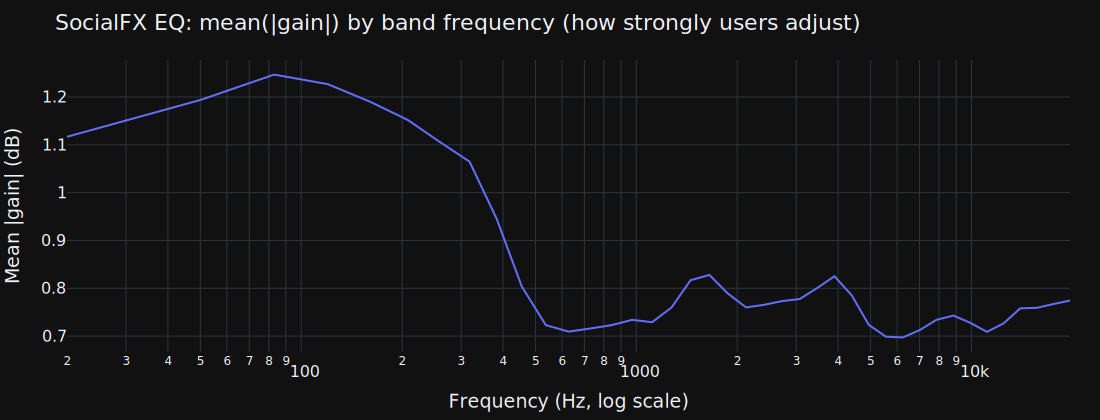

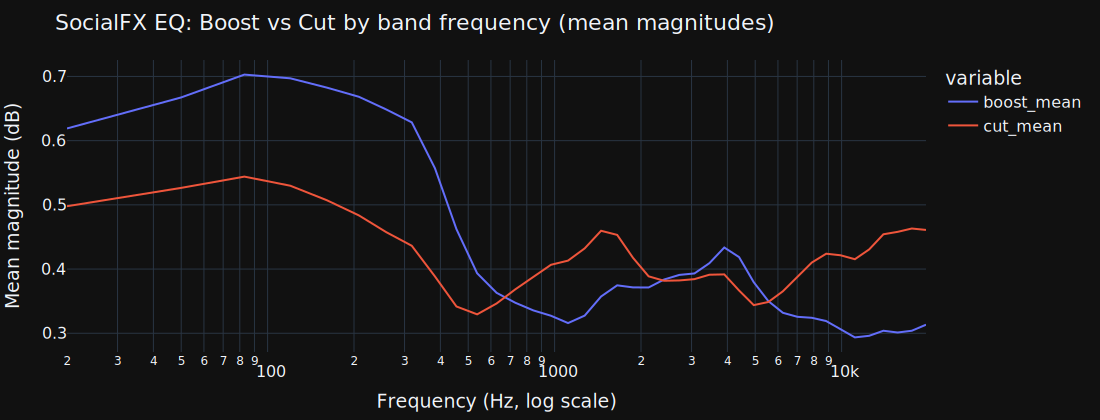

In [119]:
import plotly.express as px

agg = (eq_long.assign(abs_gain=lambda d: d["gain_db"].abs(),
                      boost=lambda d: np.clip(d["gain_db"], 0, None),
                      cut=lambda d: np.clip(-d["gain_db"], 0, None))
       .groupby("fc_hz")
       .agg(
           mean_abs_gain=("abs_gain","mean"),
           mean_gain=("gain_db","mean"),
           boost_mean=("boost","mean"),
           cut_mean=("cut","mean"),
       )
       .reset_index()
       .sort_values("fc_hz"))

fig = px.line(agg, x="fc_hz", y="mean_abs_gain",
              title="SocialFX EQ: mean(|gain|) by band frequency (how strongly users adjust)")
fig.update_layout(**COMMON_LAYOUT)
fig.update_xaxes(type="log", title="Frequency (Hz, log scale)")
fig.update_yaxes(title="Mean |gain| (dB)")
fig.show(renderer="svg")

fig.write_image(OUTPUT_PLOT / "SocialFX EQ mean(gain) by band frequency (how strongly users adjust).png", scale=2)


fig = px.line(agg, x="fc_hz", y=["boost_mean","cut_mean"],
              title="SocialFX EQ: Boost vs Cut by band frequency (mean magnitudes)")
fig.update_layout(**COMMON_LAYOUT)
fig.update_xaxes(type="log", title="Frequency (Hz, log scale)")
fig.update_yaxes(title="Mean magnitude (dB)")
fig.show(renderer="svg")

fig.write_image(OUTPUT_PLOT / "SocialFX EQ Boost vs Cut by band frequency (mean magnitudes).png", scale=2)



In [120]:
import pandas as pd
import numpy as np
import ast

def extra_get(d, key, default=np.nan):
    d = ast.literal_eval(d)
    if isinstance(d, dict) and key in d:
        return d[key]
    return default

# вытащим самые полезные поля
eq_meta = eq_df.copy()
eq_meta["lang"] = eq_meta["extra"].apply(lambda x: extra_get(x, "lang"))
eq_meta["ratings_consistency"] = eq_meta["extra"].apply(lambda x: extra_get(x, "ratings_consistency"))


eq_meta[["id", "text", "lang", "ratings_consistency"]].head()

,id,text,lang,ratings_consistency
0,eq_0,hot,English,0.797209
1,eq_1,wet,English,0.481343
2,eq_2,slow,English,0.330263
3,eq_3,saucy,English,0.188054
4,eq_4,heavy,English,0.527054


In [121]:
eq_long_m = eq_long.merge(
    eq_meta[["id", "ratings_consistency", "lang"]],
    on="id",
    how="left"
)
eq_long_m.head()

,id,text,family,fc_hz,gain_db,param_key,ratings_consistency,lang
0,eq_0,hot,RSC,20.0,-1.287298,RSC_20Hz_band,0.797209,English
1,eq_0,hot,RSC,50.0,-1.532964,RSC_50Hz_band,0.797209,English
2,eq_0,hot,RSC,83.0,-1.506539,RSC_83Hz_band,0.797209,English
3,eq_0,hot,RSC,120.0,-1.396974,RSC_120Hz_band,0.797209,English
4,eq_0,hot,RSC,161.0,-1.271199,RSC_161Hz_band,0.797209,English


In [122]:
eq_long_f = eq_long_m[eq_long_m["ratings_consistency"] >= 0.5].copy()
print("rows before:", len(eq_long_m), "after:", len(eq_long_f))

rows before: 63800 after: 30800


In [123]:
wimp = (eq_long_m
        .assign(w = eq_long_m["gain_db"].abs() * eq_long_m["ratings_consistency"].fillna(1.0))
        .groupby("fc_hz")["w"].mean()   # mean, потому что полос фиксировано одинаково
        .reset_index()
        .sort_values("fc_hz"))

wimp_f = (eq_long_f
        .assign(w = eq_long_f["gain_db"].abs() * eq_long_f["ratings_consistency"].fillna(1.0))
        .groupby("fc_hz")["w"].mean()
        .reset_index()
        .sort_values("fc_hz"))
wimp

,fc_hz,w
0,20.0,0.522460
1,50.0,0.569269
2,83.0,0.603042
3,120.0,0.597699
4,161.0,0.582495
5,208.0,0.565808
6,259.0,0.542794
7,318.0,0.519713
8,383.0,0.455242
9,455.0,0.375178


Используемая метрика
`w = |gain_db| × ratings_consistency`
корректно отражает **статистическую важность частот**, то есть
где эквалайзер применяется наиболее активно и согласованно.

При этом анализ показывает, что:
- низкие и нижние средние частоты доминируют по силе воздействия
- высокие частоты требуют отдельного рассмотрения с точки зрения
  перцептивной и музыкальной значимости


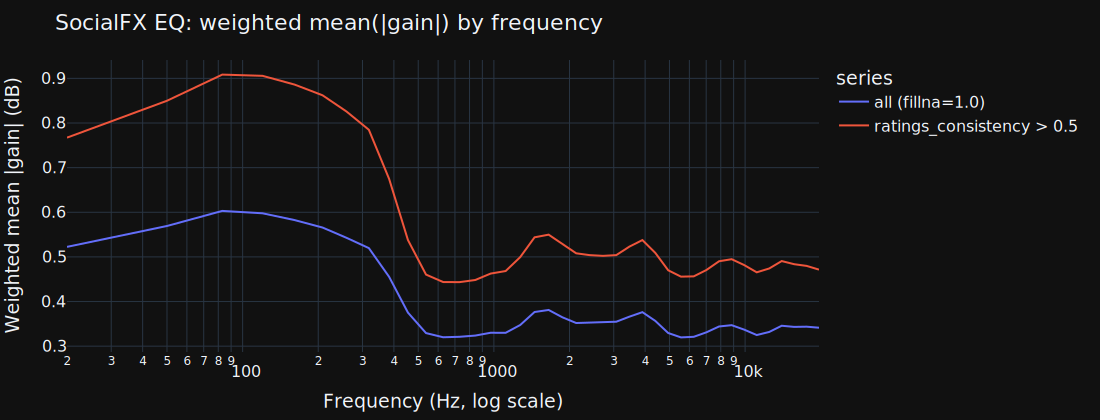

In [124]:
import plotly.express as px

w1 = wimp.assign(series="all (fillna=1.0)")
w2 = wimp_f.assign(series="ratings_consistency > 0.5")

w_both = pd.concat([w1, w2], ignore_index=True)

fig = px.line(
    w_both, x="fc_hz", y="w", color="series",
    title="SocialFX EQ: weighted mean(|gain|) by frequency"
)
fig.update_layout(**COMMON_LAYOUT)
fig.update_xaxes(type="log", title="Frequency (Hz, log scale)")
fig.update_yaxes(title="Weighted mean |gain| (dB)")
fig.show(renderer="svg")

На графике показано распределение взвешенного среднего абсолютного усиления
`mean(|gain_db|)` по частотам для эквалайзеров из датасета **SocialFX**.

Сравниваются два варианта:
- **all (fillna=1.0)** — все данные, с мягким взвешиванием по `ratings_consistency`
- **ratings_consistency > 0.5** — только более согласованные эквалайзерные решения

### Основные наблюдения

1. **Форма кривых практически идентична**
   Фильтрация по `ratings_consistency > 0.5` почти не меняет форму зависимости,
   а лишь увеличивает общий уровень значений.
   Это означает, что эквалайзерные решения в датасете в целом согласованы и не содержат
   выраженных частотных зон с низким доверием.

2. **Наибольшая важность сосредоточена в диапазоне низких и нижних средних частот**
   Максимальные значения `mean(|gain|)` наблюдаются примерно в диапазоне
   **50–300 Hz**, что соответствует зонам саббаса, баса и «мутности».
   Эти частоты наиболее активно и последовательно корректируются эквалайзером.

3. **Резкое снижение важности после ~400–600 Hz**
   В диапазоне средних частот наблюдается спад среднего абсолютного усиления,
   что указывает на более осторожную и локальную обработку этой области.

4. **Высокие частоты (2–10 kHz и выше) обрабатываются слабее, но стабильно**
   В области presence и air значения `mean(|gain|)` ниже,
   однако кривая остаётся гладкой и без резких провалов.
   Это говорит о том, что высокие частоты:
   - корректируются реже
   - с меньшей амплитудой
   - но достаточно согласованно между примерами

5. **Отсутствие сильных пиков в зоне >10 kHz не означает её неважность**
   Низкие значения в области air объясняются малой величиной применяемого усиления,
   а не отсутствием эквалайзерных решений в этом диапазоне.
   Высокие частоты чаще используются для тонкой «полировки» звука,
   что не отражается в метрике, основанной на абсолютной величине gain.

In [125]:
top_freqs = (
    wimp
    .sort_values("w", ascending=False)
    .head(10)
)
top_freqs

,fc_hz,w
2,83.0,0.603042
3,120.0,0.597699
4,161.0,0.582495
1,50.0,0.569269
5,208.0,0.565808
6,259.0,0.542794
0,20.0,0.522460
7,318.0,0.519713
8,383.0,0.455242
18,1652.0,0.381097


Высокая локальная важность частот и соседние частоты дублируют друг друга

In [126]:
from sklearn.cluster import KMeans

df = wimp.copy()

X = np.log10(df[["fc_hz"]].values)
weights = df["w"].values

In [127]:
k = 8
kmeans = KMeans(n_clusters=k, random_state=0)
labels = kmeans.fit_predict(X, sample_weight=weights)

df["cluster"] = labels

In [128]:
important_freqs = (
    df.sort_values("w", ascending=False)
      .groupby("cluster")
      .head(1)
      .sort_values("fc_hz")
)
important_freqs

,fc_hz,w,cluster
2,83.0,0.603042,3
3,120.0,0.597699,1
6,259.0,0.542794,6
16,1273.0,0.347369,5
18,1652.0,0.381097,0
25,3901.0,0.376188,7
32,8839.0,0.347018,2
36,13984.0,0.345734,4


у нас есть 1 кластер на высотах больше 10000hz что не укладывается в диапазон presence / high / air из за низкой важности, поэтому мы не много с читерим

In [129]:
w = wimp.copy()
air_bonus = 1.6
w["w_final"] = w["w"] * np.where(w["fc_hz"] >= 10000, air_bonus, 1.0)

In [130]:
k = 12
X = np.log10(w[["fc_hz"]].values)

kmeans = KMeans(n_clusters=k, random_state=0, n_init="auto")
w["cluster"] = kmeans.fit_predict(X, sample_weight=w["w_final"].values)


best = (w.sort_values("w_final", ascending=False)
          .groupby("cluster")
          .head(1)
          .sort_values("fc_hz")
          .reset_index(drop=True))

best

,fc_hz,w,w_final,cluster
0,20.0,0.522460,0.522460,4
1,50.0,0.569269,0.569269,6
2,83.0,0.603042,0.603042,9
3,120.0,0.597699,0.597699,1
4,259.0,0.542794,0.542794,8
5,455.0,0.375178,0.375178,3
6,1452.0,0.376519,0.376519,7
7,1652.0,0.381097,0.381097,0
8,3901.0,0.376188,0.376188,11
9,7014.0,0.330999,0.330999,5


In [131]:
from pathlib import Path

SAVE_PATH = Path("../../datasets/socialfx_analysis")
SAVE_PATH.mkdir(parents=True, exist_ok=True)

In [132]:
eq_long_m.assign(
    w = eq_long_m["gain_db"].abs() * eq_long_m["ratings_consistency"].fillna(1.0)
).to_csv(
    SAVE_PATH / "socialfx_eq_long_with_w.csv",
    index=False
)

In [133]:
wimp.to_csv(
    SAVE_PATH / "socialfx_wimp.csv",
    index=False
)

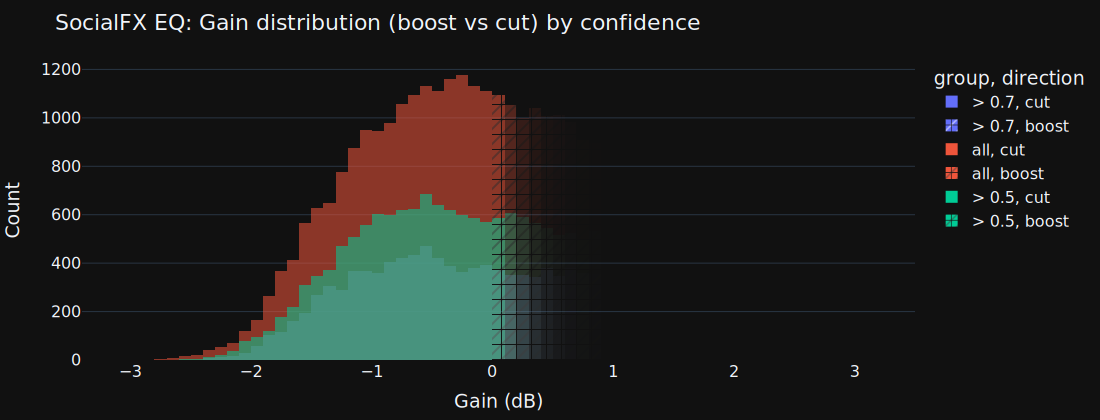

In [134]:

base = eq_long_m.dropna(subset=["gain_db"]).copy()
base = base[base["gain_db"] != 0]

base["direction"] = base["gain_db"].apply(lambda x: "boost" if x > 0 else "cut")
base["group"] = base["ratings_consistency"].apply(
    lambda rc: "> 0.7" if rc > 0.7 else ("> 0.5" if rc > 0.5 else "all")
)

fig = px.histogram(
    base,
    x="gain_db",
    color="group",
    pattern_shape="direction",   # <-- boost/cut внутри одного графика
    nbins=120,
    barmode="overlay",
    opacity=0.55,
    title="SocialFX EQ: Gain distribution (boost vs cut) by confidence"
)

fig.update_layout(**COMMON_LAYOUT)
fig.update_xaxes(title="Gain (dB)", zeroline=False)
fig.update_yaxes(title="Count", zeroline=False)
fig.show(renderer="svg")

## Выводы по распределению усилений (boost vs cut)

На графике показано распределение значений усиления (`gain_db`)
для эквалайзеров SocialFX с разделением:

- по направлению коррекции (**boost / cut**)
- по уровню согласованности (`ratings_consistency`):
  - все данные
  - `> 0.5`
  - `> 0.7`

### Основные наблюдения

1. **Большинство эквалайзерных коррекций имеют малую амплитуду**
   Независимо от направления (boost или cut),
   основная масса значений сосредоточена в диапазоне примерно:

   ```text
   −2 dB … +2 dB
